In [1]:
import torch
import numpy as np
from training import train
from data_utils import make_dataset, load_dataset, fit_dset_to_m, make_grid_dataset
from controls import LQR
from tasks import stabilize_cartpole
from plotting import plot_trajectories, plot_experiment_new
from models import save_model, load_model
from experiments import run_experiment, save_experiment, load_experiment
import params
from IPython.display import HTML
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

######################
### DISPLAY CONFIG ###
######################
for name, values in vars(params).items():
    print(name, values)

torch.set_default_device("cuda")
#torch.set_default_device("cpu")

%load_ext autoreload
%autoreload 2

/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


__name__ params
__doc__ None
__package__ 
__loader__ <_frozen_importlib_external.SourceFileLoader object at 0x7ffa1c2730b0>
__spec__ ModuleSpec(name='params', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7ffa1c2730b0>, origin='/home1/lutkus/latent_space/cartpole_lyapunov/params.py')
__file__ /home1/lutkus/latent_space/cartpole_lyapunov/params.py
__cached__ /home1/lutkus/latent_space/cartpole_lyapunov/__pycache__/params.cpython-313.pyc
__builtins__ {'__name__': 'builtins', '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis module is not normally accessed explicitly by most\napplications, but can be useful in modules that provide\nobjects with the same name as a built-in value, but in\nwhich the built-in of that name is also needed.", '__package__': '', '__loader__': <class '_frozen_impor

In [2]:
#data = make_dataset(save=True, fname=params.dataset, render_mode=None, expert_controller=False)
#data = make_grid_dataset([0.5, 0.5, 0.5, 0.5], [3], 10)
#data = make_grid_dataset(params.grid_x_ranges, params.grid_u_ranges, params.grid_n_per_axis)
data = load_dataset(fname=params.dataset)
X, U, Xtest, Utest = data
'''
data_rand = load_dataset(fname=params.dataset2)
X0, U0 = fit_dset_to_m(X[0], U[0])
X = (torch.vstack([X0,data_rand[0][0]]), torch.vstack([X[1],data_rand[0][1]]))
U = (torch.vstack([U0,data_rand[1][0]]), None)
Xtest0, Utest0 = fit_dset_to_m(Xtest[0], Utest[0])
Xtest = (torch.vstack([Xtest0,data_rand[2][0]]), torch.vstack([Xtest[1],data_rand[2][1]]))
Utest = (torch.vstack([Utest0,data_rand[3][0]]), None)
print("DSET SIZES:")
print(X[0].shape)
print(X[1].shape)
'''

/home1/lutkus/.conda/envs/latent-space/lib/python3.13/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


'\ndata_rand = load_dataset(fname=params.dataset2)\nX0, U0 = fit_dset_to_m(X[0], U[0])\nX = (torch.vstack([X0,data_rand[0][0]]), torch.vstack([X[1],data_rand[0][1]]))\nU = (torch.vstack([U0,data_rand[1][0]]), None)\nXtest0, Utest0 = fit_dset_to_m(Xtest[0], Utest[0])\nXtest = (torch.vstack([Xtest0,data_rand[2][0]]), torch.vstack([Xtest[1],data_rand[2][1]]))\nUtest = (torch.vstack([Utest0,data_rand[3][0]]), None)\nprint("DSET SIZES:")\nprint(X[0].shape)\nprint(X[1].shape)\n'

15
original state:
 [(0, 1, 3), (2,)]
n_combinations 4
n_params 2
{'ae': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'ae_opt': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn_opt': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'ae_list': [('symbols=(0, 1, 2, 3)\nignored=()', []), ('symbols=(0, 1, 3)\nignored=(2,)', []), ('symbols=(1, 2, 3)\nignored=(0,)', []), ('symbols=(1, 3)\nignored=(0, 2)', [])], 'fdyn_list': [('symbols=(0, 1, 2, 3)\nignored=()', []), 

  1%|          | 1/100 [00:24<40:19, 24.44s/it]

ep 0: train 0.6673115491867065    test 7.326438903808594
rec 0.4932527244091034    mstep 0.17405807971954346    jac 0.0
horizon is now 2


  2%|▏         | 2/100 [00:46<37:37, 23.03s/it]

3.1438956
it: 2; avg reward: 1275.112065122921; completion rate: 0.5; gamma_max: 3.1438956260681152
horizon is now 3


  3%|▎         | 3/100 [01:21<45:45, 28.30s/it]

horizon is now 4


  4%|▍         | 4/100 [01:49<45:11, 28.25s/it]

1.7836778
it: 4; avg reward: 1476.0410319396328; completion rate: 0.53; gamma_max: 1.7836778163909912
horizon is now 5


  5%|▌         | 5/100 [02:29<51:29, 32.52s/it]

horizon is now 6


  6%|▌         | 6/100 [03:05<53:05, 33.89s/it]

1.5316294
it: 6; avg reward: 1027.6675648078035; completion rate: 0.72; gamma_max: 1.5316294431686401
horizon is now 7


  7%|▋         | 7/100 [03:55<1:00:42, 39.17s/it]

horizon is now 8


  8%|▊         | 8/100 [04:40<1:02:52, 41.00s/it]

1.5497884
it: 8; avg reward: 1454.446435956681; completion rate: 0.7; gamma_max: 1.5497883558273315
horizon is now 9


  9%|▉         | 9/100 [05:38<1:10:15, 46.33s/it]

horizon is now 10


 10%|█         | 10/100 [06:31<1:12:35, 48.40s/it]

1.261146
it: 10; avg reward: 1209.1176014831865; completion rate: 0.82; gamma_max: 1.2611459493637085
horizon is now 11


 11%|█         | 11/100 [07:38<1:20:05, 53.99s/it]

horizon is now 12


 12%|█▏        | 12/100 [08:39<1:22:21, 56.15s/it]

0.98214626
it: 12; avg reward: 939.7780471837417; completion rate: 0.82; gamma_max: 0.9821462631225586
horizon is now 13


 13%|█▎        | 13/100 [09:54<1:29:40, 61.84s/it]

horizon is now 14


 14%|█▍        | 14/100 [11:03<1:31:43, 63.99s/it]

1.0838917
it: 14; avg reward: 1479.7547883584652; completion rate: 0.8; gamma_max: 1.083891749382019
horizon is now 15


 16%|█▌        | 16/100 [13:39<1:38:54, 70.65s/it]

1.0133091
it: 16; avg reward: 1708.747867971705; completion rate: 0.79; gamma_max: 1.013309121131897


 18%|█▊        | 18/100 [16:14<1:40:53, 73.82s/it]

1.0292189
it: 18; avg reward: 1323.7001954226587; completion rate: 0.81; gamma_max: 1.0292189121246338


 20%|██        | 20/100 [18:50<1:40:37, 75.47s/it]

0.81942976
it: 20; avg reward: 1247.1203863543838; completion rate: 0.85; gamma_max: 0.8194297552108765


 22%|██▏       | 22/100 [21:25<1:39:05, 76.22s/it]

0.77409714
it: 22; avg reward: 1244.7457167654625; completion rate: 0.86; gamma_max: 0.7740971446037292


 24%|██▍       | 24/100 [24:01<1:37:01, 76.60s/it]

0.6983717
it: 24; avg reward: 1296.5431448053153; completion rate: 0.84; gamma_max: 0.6983717083930969


 26%|██▌       | 26/100 [26:37<1:34:48, 76.87s/it]

0.68534696
it: 26; avg reward: 1473.8249003912752; completion rate: 0.85; gamma_max: 0.6853469610214233


 28%|██▊       | 28/100 [29:13<1:32:19, 76.94s/it]

0.5950416
it: 28; avg reward: 1753.7924822411694; completion rate: 0.84; gamma_max: 0.5950415730476379


 30%|███       | 30/100 [31:49<1:29:51, 77.02s/it]

0.5157012
it: 30; avg reward: 1140.2473553638065; completion rate: 0.84; gamma_max: 0.515701174736023


 32%|███▏      | 32/100 [34:24<1:27:11, 76.93s/it]

0.52311105
it: 32; avg reward: 1539.268371810536; completion rate: 0.85; gamma_max: 0.5231110453605652


 34%|███▍      | 34/100 [37:00<1:24:34, 76.89s/it]

0.38095766
it: 34; avg reward: 1240.7629059712258; completion rate: 0.86; gamma_max: 0.3809576630592346


 36%|███▌      | 36/100 [39:35<1:22:00, 76.88s/it]

0.4683974
it: 36; avg reward: 1504.4664709917838; completion rate: 0.69; gamma_max: 0.4683974087238312


 38%|███▊      | 38/100 [42:09<1:19:04, 76.52s/it]

0.2974683
it: 38; avg reward: 1409.3417546563555; completion rate: 0.8; gamma_max: 0.29746830463409424


 40%|████      | 40/100 [44:44<1:16:40, 76.67s/it]

0.3522712
it: 40; avg reward: 1144.187373142515; completion rate: 0.88; gamma_max: 0.3522711992263794


 42%|████▏     | 42/100 [47:20<1:14:11, 76.74s/it]

0.40787765
it: 42; avg reward: 1609.8159056762618; completion rate: 0.85; gamma_max: 0.407877653837204


 44%|████▍     | 44/100 [49:55<1:11:32, 76.64s/it]

0.3719298
it: 44; avg reward: 1307.233394916393; completion rate: 0.87; gamma_max: 0.371929794549942


 46%|████▌     | 46/100 [52:30<1:08:57, 76.62s/it]

0.35858902
it: 46; avg reward: 1507.6628807605687; completion rate: 0.74; gamma_max: 0.3585890233516693


 48%|████▊     | 48/100 [55:04<1:06:20, 76.54s/it]

0.29479575
it: 48; avg reward: 1161.794617072197; completion rate: 0.8; gamma_max: 0.2947957515716553


 50%|█████     | 50/100 [57:39<1:03:45, 76.51s/it]

0.40605766
it: 50; avg reward: 1323.1273365946722; completion rate: 0.8; gamma_max: 0.4060576558113098


 52%|█████▏    | 52/100 [1:00:14<1:01:12, 76.51s/it]

0.39044547
it: 52; avg reward: 1418.3943292783292; completion rate: 0.78; gamma_max: 0.3904454708099365


 54%|█████▍    | 54/100 [1:02:49<58:47, 76.69s/it]  

0.28521216
it: 54; avg reward: 1229.080641423203; completion rate: 0.8; gamma_max: 0.2852121591567993


 56%|█████▌    | 56/100 [1:05:24<56:12, 76.65s/it]

0.3590417
it: 56; avg reward: 1363.6880642818476; completion rate: 0.86; gamma_max: 0.359041690826416


 58%|█████▊    | 58/100 [1:07:59<53:43, 76.76s/it]

0.37799832
it: 58; avg reward: 1420.9314775366245; completion rate: 0.77; gamma_max: 0.37799832224845886


 60%|██████    | 60/100 [1:10:34<51:04, 76.62s/it]

0.23471007
it: 60; avg reward: 1038.6006831228092; completion rate: 0.84; gamma_max: 0.23471006751060486


 62%|██████▏   | 62/100 [1:13:10<48:42, 76.91s/it]

0.34574214
it: 62; avg reward: 1435.5906362626172; completion rate: 0.79; gamma_max: 0.3457421362400055


 64%|██████▍   | 64/100 [1:15:45<46:04, 76.78s/it]

0.4010973
it: 64; avg reward: 1542.636811066242; completion rate: 0.77; gamma_max: 0.40109729766845703


 66%|██████▌   | 66/100 [1:18:20<43:26, 76.66s/it]

0.37395954
it: 66; avg reward: 1170.6449280540849; completion rate: 0.8; gamma_max: 0.3739595413208008


 68%|██████▊   | 68/100 [1:20:55<40:53, 76.68s/it]

0.36574975
it: 68; avg reward: 1529.6358434608665; completion rate: 0.84; gamma_max: 0.3657497465610504


 70%|███████   | 70/100 [1:23:30<38:22, 76.76s/it]

0.39562985
it: 70; avg reward: 2069.3949918661556; completion rate: 0.83; gamma_max: 0.3956298530101776


 72%|███████▏  | 72/100 [1:26:06<35:56, 77.01s/it]

0.33904096
it: 72; avg reward: 1295.2353801400143; completion rate: 0.82; gamma_max: 0.33904096484184265


 74%|███████▍  | 74/100 [1:28:42<33:19, 76.90s/it]

0.20283985
it: 74; avg reward: 1163.7315443981745; completion rate: 0.79; gamma_max: 0.20283985137939453


 76%|███████▌  | 76/100 [1:31:16<30:40, 76.70s/it]

0.40253893
it: 76; avg reward: 2101.601045860342; completion rate: 0.9; gamma_max: 0.402538925409317


 78%|███████▊  | 78/100 [1:33:52<28:10, 76.83s/it]

0.31707513
it: 78; avg reward: 1812.188197192579; completion rate: 0.84; gamma_max: 0.31707513332366943


 80%|████████  | 80/100 [1:36:27<25:32, 76.63s/it]

0.35424355
it: 80; avg reward: 1555.2846402201374; completion rate: 0.86; gamma_max: 0.35424354672431946


 82%|████████▏ | 82/100 [1:39:02<23:00, 76.67s/it]

0.38925904
it: 82; avg reward: 1807.7699268691792; completion rate: 0.83; gamma_max: 0.3892590403556824


 84%|████████▍ | 84/100 [1:41:37<20:24, 76.51s/it]

0.29493365
it: 84; avg reward: 1698.7020263244483; completion rate: 0.88; gamma_max: 0.29493364691734314


 86%|████████▌ | 86/100 [1:44:11<17:51, 76.51s/it]

0.30158696
it: 86; avg reward: 1431.5229974431804; completion rate: 0.87; gamma_max: 0.30158695578575134


 88%|████████▊ | 88/100 [1:46:46<15:18, 76.54s/it]

0.3389083
it: 88; avg reward: 1414.2006634311347; completion rate: 0.78; gamma_max: 0.338908314704895


 90%|█████████ | 90/100 [1:49:21<12:45, 76.59s/it]

0.36418518
it: 90; avg reward: 1466.1154153963423; completion rate: 0.85; gamma_max: 0.3641851842403412


 92%|█████████▏| 92/100 [1:52:04<10:29, 78.65s/it]

0.37810725
it: 92; avg reward: 1778.536234862644; completion rate: 0.85; gamma_max: 0.3781072497367859


 94%|█████████▍| 94/100 [1:54:40<07:47, 77.92s/it]

0.36959878
it: 94; avg reward: 1475.069673551142; completion rate: 0.88; gamma_max: 0.36959877610206604


 96%|█████████▌| 96/100 [1:57:15<05:09, 77.39s/it]

0.2756825
it: 96; avg reward: 1276.5909845261942; completion rate: 0.81; gamma_max: 0.2756825089454651


 98%|█████████▊| 98/100 [1:59:50<02:33, 76.87s/it]

0.3495529
it: 98; avg reward: 1494.374636090053; completion rate: 0.89; gamma_max: 0.3495528995990753


100%|██████████| 100/100 [2:02:54<00:00, 73.74s/it]

ep 99: train 0.6012890338897705    test 0.6165645718574524
rec 0.13769516348838806    mstep 0.4635946452617645    jac 0.0


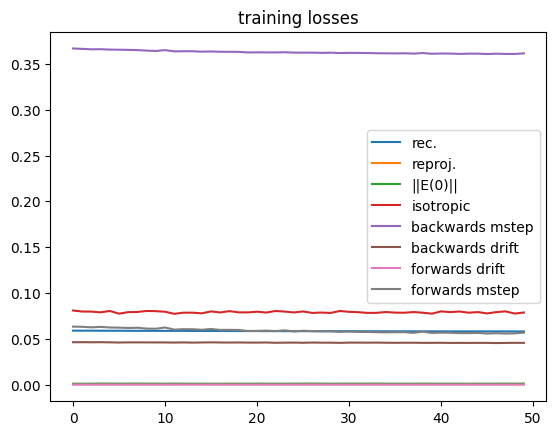

ENCODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f3ae74af6a0>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f3ae74af6a0>
g bias init is nn.init.zeros


DECODER


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f3ae74af6a0>
g bias init is nn.init.zeros


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f3ae74af6a0>
g bias init is nn.init.zeros


LATENT DRIFT


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f3ae74af6a0>
g bias init is <function uniform_ at 0x7f3ae74af060>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f3ae74af6a0>
g bias init is <function uniform_ at 0x7f3ae74af060>


LATENT CONTROL


### Layer 0 ###
Not residual
g init is <function xavier_uniform_ at 0x7f3ae74af6a0>
g bias init is <function zeros_ at 0x7f3ae74af420>


### Layer 1 ###
Not residual
g init is <function xavier_uniform_ at 0x7f3

  1%|          | 1/100 [00:21<35:55, 21.77s/it]

ep 0: train 0.49260810017585754    test 8.18399715423584
rec 0.32431578636169434    mstep 0.16829217970371246    jac 0.0
horizon is now 2


  2%|▏         | 2/100 [00:41<33:23, 20.44s/it]

2.0111287
it: 2; avg reward: 1705.6919009372864; completion rate: 0.56; gamma_max: 2.0111286640167236
horizon is now 3


  3%|▎         | 3/100 [01:12<40:50, 25.27s/it]

horizon is now 4


  4%|▍         | 4/100 [01:39<41:46, 26.11s/it]

1.0780811
it: 4; avg reward: 947.610469380695; completion rate: 0.73; gamma_max: 1.0780811309814453
horizon is now 5


  5%|▌         | 5/100 [02:19<49:26, 31.23s/it]

horizon is now 6


  6%|▌         | 6/100 [02:55<51:25, 32.83s/it]

0.9232763
it: 6; avg reward: 1148.9074572345758; completion rate: 0.74; gamma_max: 0.9232763051986694
horizon is now 7


  7%|▋         | 7/100 [03:45<59:10, 38.18s/it]

horizon is now 8


  8%|▊         | 8/100 [04:29<1:01:33, 40.15s/it]

0.94660836
it: 8; avg reward: 1204.0498433647288; completion rate: 0.82; gamma_max: 0.9466083645820618
horizon is now 9


  9%|▉         | 9/100 [05:27<1:09:20, 45.72s/it]

horizon is now 10


 10%|█         | 10/100 [06:19<1:11:38, 47.77s/it]

0.9441319
it: 10; avg reward: 1140.7449858671587; completion rate: 0.77; gamma_max: 0.9441319108009338
horizon is now 11


 11%|█         | 11/100 [07:25<1:18:52, 53.17s/it]

horizon is now 12


 12%|█▏        | 12/100 [08:25<1:21:10, 55.35s/it]

1.0427796
it: 12; avg reward: 1493.5665006485613; completion rate: 0.85; gamma_max: 1.042779564857483
horizon is now 13


 13%|█▎        | 13/100 [09:39<1:28:28, 61.02s/it]

horizon is now 14


 14%|█▍        | 14/100 [10:49<1:31:12, 63.64s/it]

1.0432441
it: 14; avg reward: 1563.762971788371; completion rate: 0.81; gamma_max: 1.0432441234588623
horizon is now 15


 16%|█▌        | 16/100 [13:23<1:38:03, 70.04s/it]

1.1009808
it: 16; avg reward: 1756.960585092241; completion rate: 0.86; gamma_max: 1.1009807586669922


 18%|█▊        | 18/100 [15:56<1:39:48, 73.03s/it]

1.0336475
it: 18; avg reward: 1582.6350292562215; completion rate: 0.93; gamma_max: 1.0336475372314453


 20%|██        | 20/100 [18:31<1:39:39, 74.75s/it]

1.0097328
it: 20; avg reward: 1623.0117219542701; completion rate: 0.96; gamma_max: 1.0097328424453735


 22%|██▏       | 22/100 [21:05<1:38:11, 75.53s/it]

1.1647993
it: 22; avg reward: 2093.9012620027756; completion rate: 0.93; gamma_max: 1.1647993326187134


 24%|██▍       | 24/100 [23:40<1:36:13, 75.97s/it]

1.0304508
it: 24; avg reward: 1456.534226059966; completion rate: 0.95; gamma_max: 1.0304508209228516


 26%|██▌       | 26/100 [26:14<1:33:53, 76.13s/it]

0.9529572
it: 26; avg reward: 1918.928954747794; completion rate: 0.91; gamma_max: 0.9529572129249573


 28%|██▊       | 28/100 [28:48<1:31:21, 76.13s/it]

0.9262218
it: 28; avg reward: 1902.5450608418832; completion rate: 0.87; gamma_max: 0.9262217879295349


 30%|███       | 30/100 [31:22<1:28:50, 76.15s/it]

0.82633173
it: 30; avg reward: 1678.3364967173886; completion rate: 0.9; gamma_max: 0.8263317346572876


 32%|███▏      | 32/100 [33:56<1:26:17, 76.14s/it]

0.7883914
it: 32; avg reward: 1805.3957767249292; completion rate: 0.89; gamma_max: 0.7883914113044739


 34%|███▍      | 34/100 [36:31<1:23:52, 76.24s/it]

0.728018
it: 34; avg reward: 1877.664997730185; completion rate: 0.96; gamma_max: 0.7280179858207703


 36%|███▌      | 36/100 [39:05<1:21:22, 76.28s/it]

0.659335
it: 36; avg reward: 1547.8416380472645; completion rate: 0.92; gamma_max: 0.6593350172042847


 38%|███▊      | 38/100 [41:40<1:18:47, 76.25s/it]

0.5481843
it: 38; avg reward: 1501.768047846005; completion rate: 0.87; gamma_max: 0.5481842756271362


 42%|████▏     | 42/100 [46:48<1:13:35, 76.13s/it]

0.5635622
it: 42; avg reward: 1956.9332106974166; completion rate: 0.92; gamma_max: 0.5635622143745422


 44%|████▍     | 44/100 [49:22<1:11:06, 76.20s/it]

0.55508155
it: 44; avg reward: 1638.1462331904056; completion rate: 0.9; gamma_max: 0.5550815463066101


 46%|████▌     | 46/100 [51:56<1:08:34, 76.19s/it]

0.42256638
it: 46; avg reward: 1825.6143590913885; completion rate: 0.82; gamma_max: 0.42256638407707214


 48%|████▊     | 48/100 [54:30<1:06:00, 76.16s/it]

0.470594
it: 48; avg reward: 1615.4233775723778; completion rate: 0.93; gamma_max: 0.47059398889541626


 50%|█████     | 50/100 [57:04<1:03:30, 76.21s/it]

0.45416167
it: 50; avg reward: 1615.6636088449357; completion rate: 0.91; gamma_max: 0.454161673784256


 52%|█████▏    | 52/100 [59:39<1:00:57, 76.21s/it]

0.43989336
it: 52; avg reward: 1806.2110993239946; completion rate: 0.88; gamma_max: 0.43989336490631104


 54%|█████▍    | 54/100 [1:02:13<58:32, 76.36s/it]  

0.39841354
it: 54; avg reward: 1743.81489169362; completion rate: 0.96; gamma_max: 0.3984135389328003


 56%|█████▌    | 56/100 [1:04:48<56:01, 76.40s/it]

0.32520875
it: 56; avg reward: 1400.011783210641; completion rate: 0.92; gamma_max: 0.32520875334739685


 58%|█████▊    | 58/100 [1:07:23<53:27, 76.37s/it]

0.37001687
it: 58; avg reward: 1562.7428041169746; completion rate: 0.94; gamma_max: 0.370016872882843


 60%|██████    | 60/100 [1:09:57<50:54, 76.37s/it]

0.37563464
it: 60; avg reward: 1973.8177526916193; completion rate: 0.93; gamma_max: 0.37563464045524597


 62%|██████▏   | 62/100 [1:12:32<48:21, 76.36s/it]

0.29469657
it: 62; avg reward: 1441.736423709362; completion rate: 0.83; gamma_max: 0.294696569442749


 64%|██████▍   | 64/100 [1:15:06<45:48, 76.34s/it]

0.2602199
it: 64; avg reward: 1361.972483405873; completion rate: 0.85; gamma_max: 0.26021990180015564


 66%|██████▌   | 66/100 [1:17:40<43:12, 76.24s/it]

0.32177672
it: 66; avg reward: 1866.4005563228936; completion rate: 0.89; gamma_max: 0.32177671790122986


 68%|██████▊   | 68/100 [1:20:14<40:38, 76.21s/it]

0.35184205
it: 68; avg reward: 2014.241712542996; completion rate: 0.87; gamma_max: 0.3518420457839966


 70%|███████   | 70/100 [1:22:48<38:06, 76.21s/it]

0.33294603
it: 70; avg reward: 2000.9541194628232; completion rate: 0.88; gamma_max: 0.3329460322856903


 72%|███████▏  | 72/100 [1:25:24<35:41, 76.47s/it]

0.2926293
it: 72; avg reward: 1431.6821286841862; completion rate: 0.89; gamma_max: 0.29262930154800415


 74%|███████▍  | 74/100 [1:27:58<33:04, 76.33s/it]

0.33455178
it: 74; avg reward: 1461.040627793833; completion rate: 0.82; gamma_max: 0.33455178141593933


 76%|███████▌  | 76/100 [1:30:31<30:27, 76.15s/it]

0.31034926
it: 76; avg reward: 1782.0986013394604; completion rate: 0.81; gamma_max: 0.3103492558002472


 78%|███████▊  | 78/100 [1:33:05<27:53, 76.08s/it]

0.34932566
it: 78; avg reward: 1633.3004444234848; completion rate: 0.81; gamma_max: 0.34932565689086914


 80%|████████  | 80/100 [1:35:39<25:20, 76.05s/it]

0.3599885
it: 80; avg reward: 1444.3345363693386; completion rate: 0.86; gamma_max: 0.3599885106086731


 82%|████████▏ | 82/100 [1:38:13<22:54, 76.33s/it]

0.38902712
it: 82; avg reward: 1671.6120707607074; completion rate: 0.82; gamma_max: 0.38902711868286133


 84%|████████▍ | 84/100 [1:40:47<20:19, 76.20s/it]

0.4233601
it: 84; avg reward: 1595.6128204173176; completion rate: 0.86; gamma_max: 0.42336010932922363


 86%|████████▌ | 86/100 [1:43:21<17:46, 76.21s/it]

0.39710772
it: 86; avg reward: 1378.3085768463534; completion rate: 0.87; gamma_max: 0.39710772037506104


 88%|████████▊ | 88/100 [1:45:56<15:14, 76.19s/it]

0.3664816
it: 88; avg reward: 1383.7641713267733; completion rate: 0.88; gamma_max: 0.36648160219192505


 90%|█████████ | 90/100 [1:48:30<12:42, 76.20s/it]

0.33819062
it: 90; avg reward: 1603.678708272328; completion rate: 0.8; gamma_max: 0.33819061517715454


 92%|█████████▏| 92/100 [1:51:03<10:08, 76.01s/it]

0.39381024
it: 92; avg reward: 1537.5651369655968; completion rate: 0.91; gamma_max: 0.3938102424144745


 94%|█████████▍| 94/100 [1:53:38<07:37, 76.33s/it]

0.3091898
it: 94; avg reward: 1146.859752315416; completion rate: 0.81; gamma_max: 0.3091897964477539


 96%|█████████▌| 96/100 [1:56:12<05:04, 76.15s/it]

0.38441628
it: 96; avg reward: 1396.5172894810623; completion rate: 0.88; gamma_max: 0.38441628217697144


 98%|█████████▊| 98/100 [1:58:46<02:32, 76.17s/it]

0.46149576
it: 98; avg reward: 1666.5317271132944; completion rate: 0.93; gamma_max: 0.4614957571029663


100%|██████████| 100/100 [2:01:50<00:00, 73.10s/it]

ep 99: train 0.6011063456535339    test 0.6026598215103149
rec 0.13695944845676422    mstep 0.4641471803188324    jac 0.0


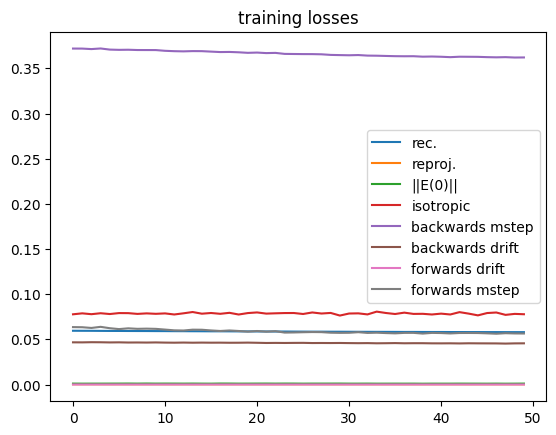

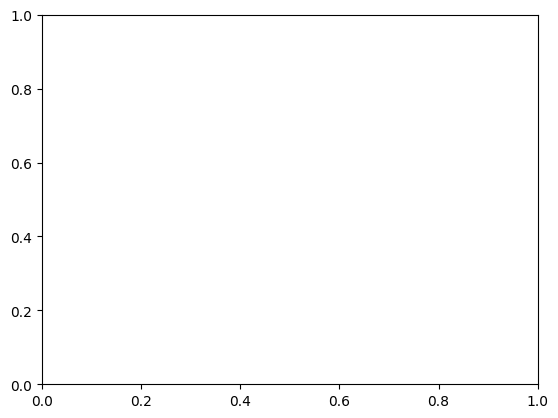

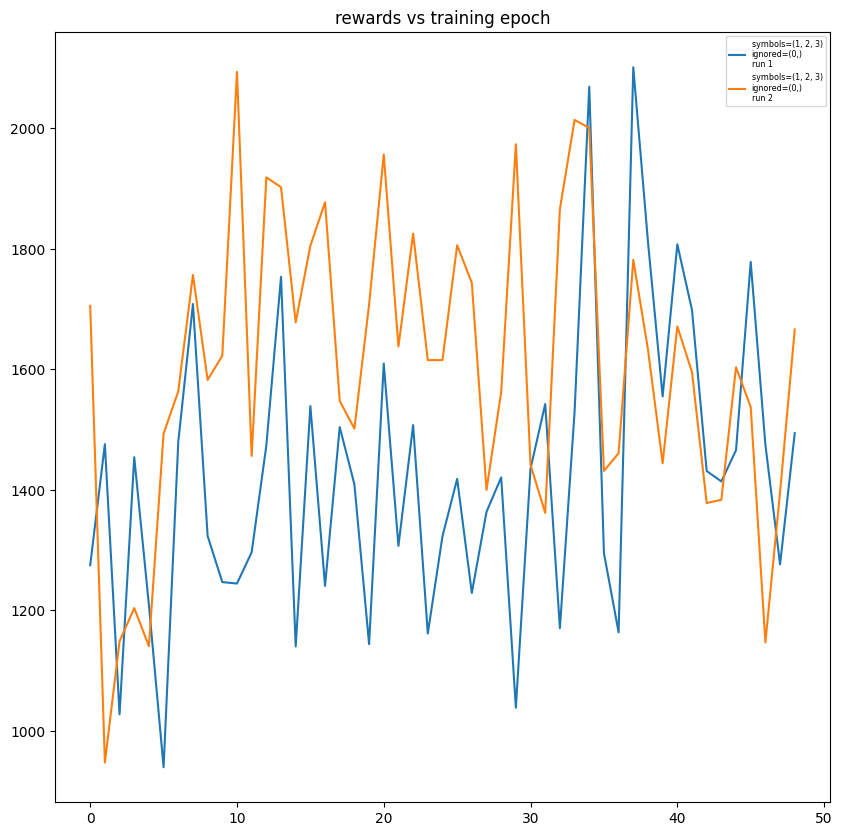

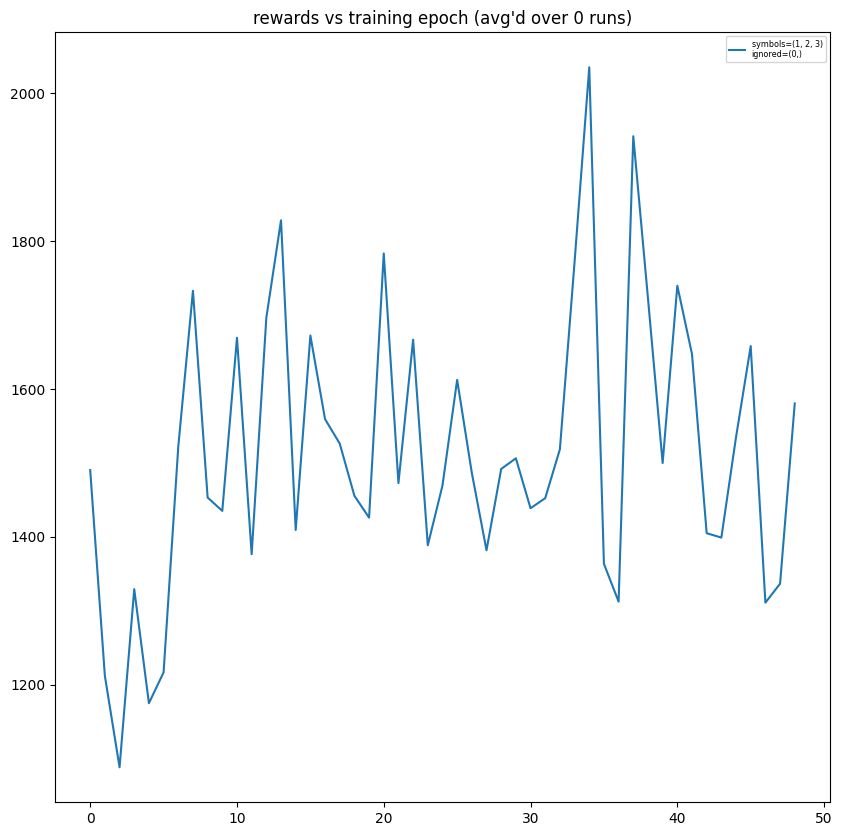

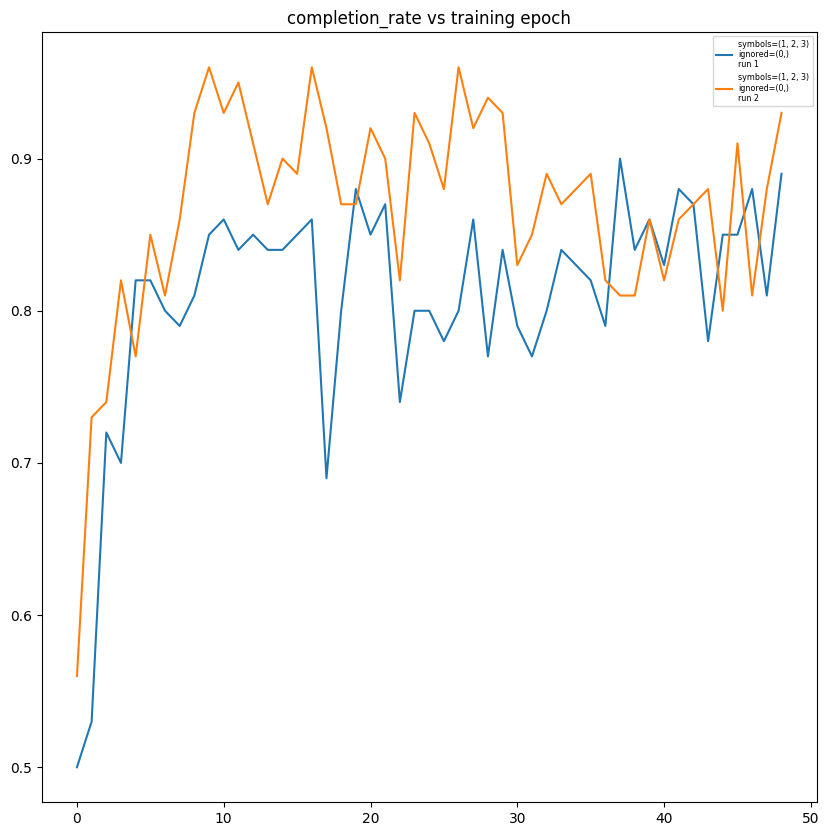

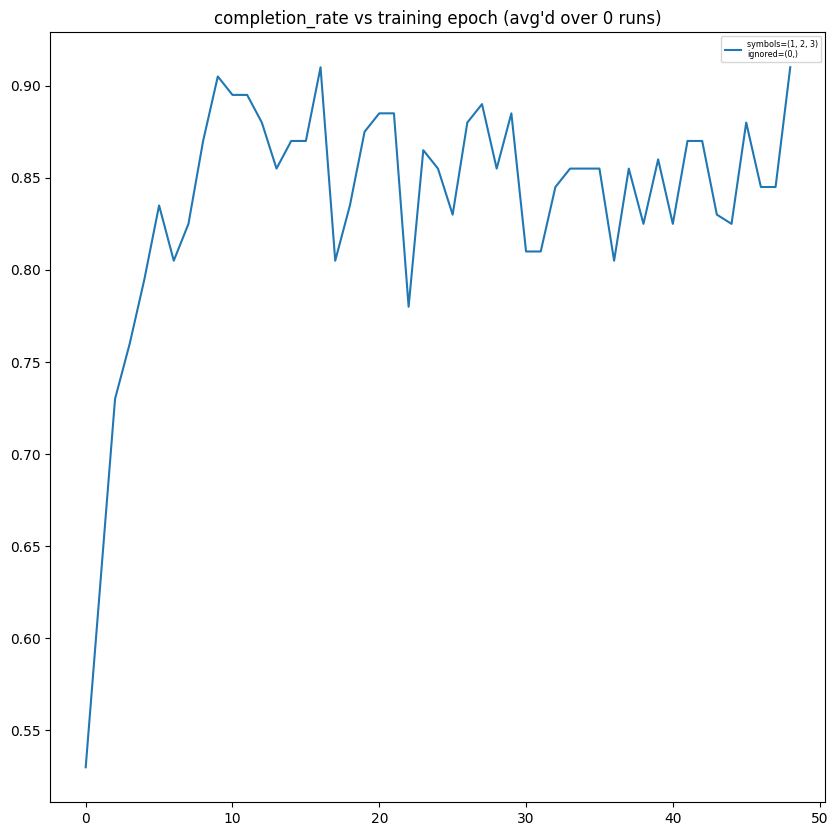

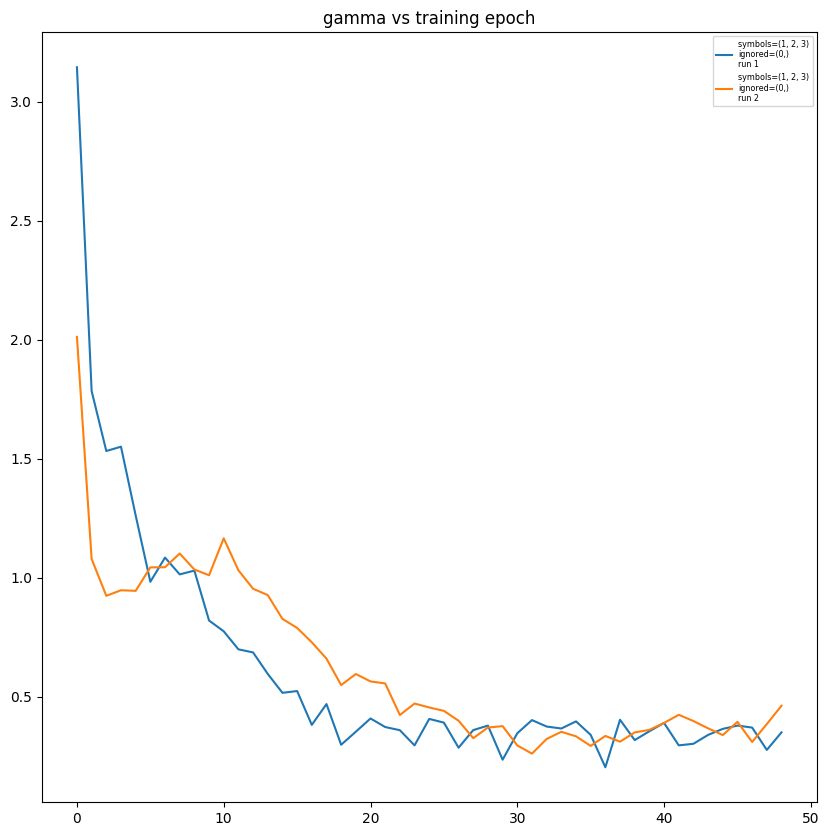

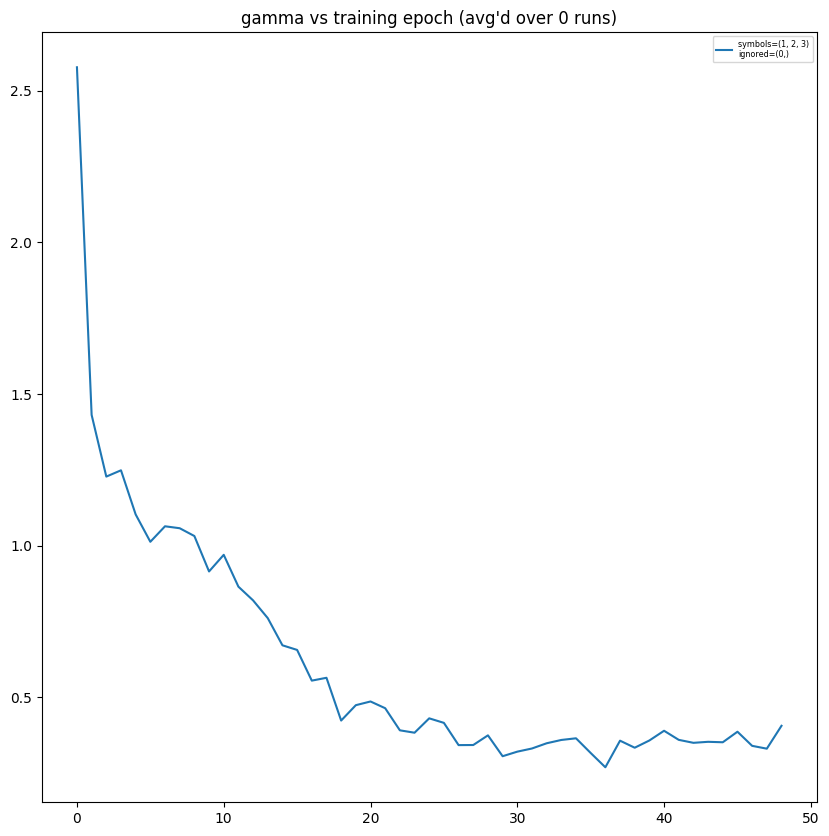

final state
 [(0, 1, 3), (2,)]
saving fwd_penalty_exp_3.pkl
15


In [3]:
from experiments import run_experiment_new
#spec = {'m':[3, 4, 5], 'rec_jac':[True, False, True], 'ptb_eps_x':[1e-9, 1e-6, 1e-3]}

'''
spec = {"predict_mstep" : [True, False, True], 
        "penalize_rec" : [True, True, True], 
        "penalize_reproj" : [False, True, True],
        "penalize_encoder_diagram_mstep" : [False, True, True]}
'''
name = 'fwd_penalty_exp_3'
'''
spec = {'m':[7, 8, 9],
        'm_schedule':[7*[0], 8*[0], 9*[0]]}
'''
spec = {'symbols': [(0,1,2,3), (0, 1, 3), (1, 2, 3), (1, 3)],
        'ignored': [(), (2,), (0,), (0, 2)]}
#n_runs = len(list(spec.items())[0][1])*[1]
n_runs = [0, 0, 2, 0]
print(params.m)
exp=run_experiment_new(data, spec, plot=True, n_runs=n_runs, fname=name, save=True)
print(params.m)


In [26]:
#######################
### Save Experiment ###
#######################

#save_name = 'nontrivial_3'
#save_name = 'BASELINE'
#save_experiment(save_name, exp)

saving BASELINE.pkl


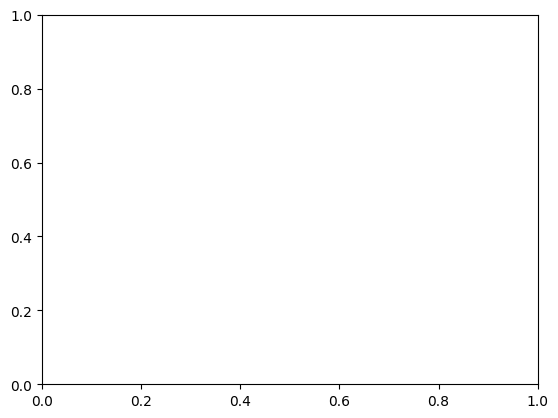

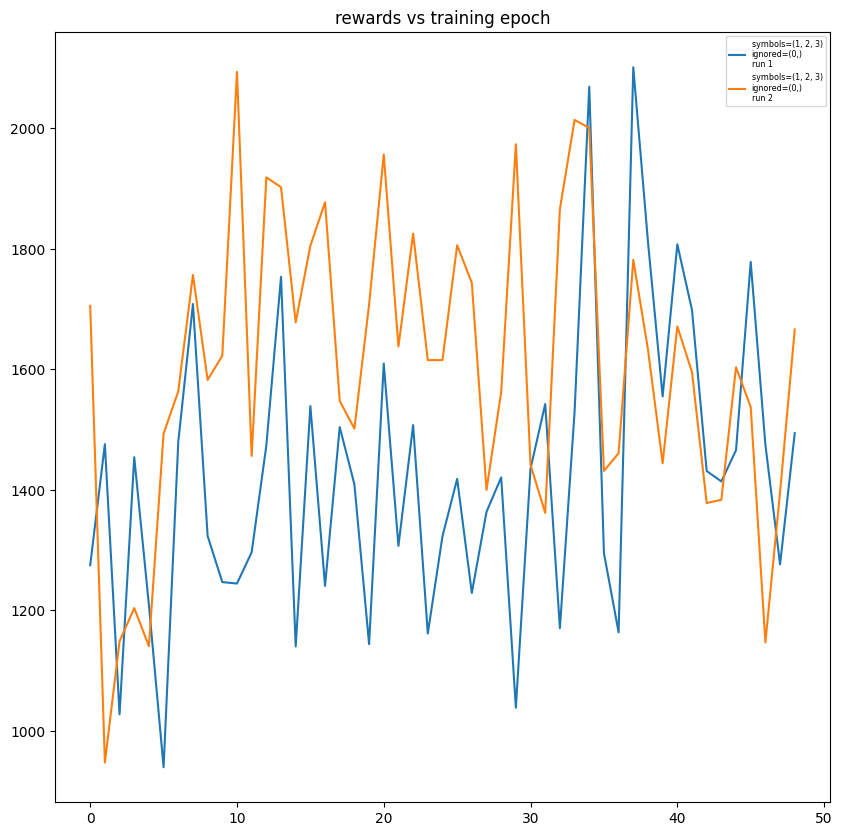

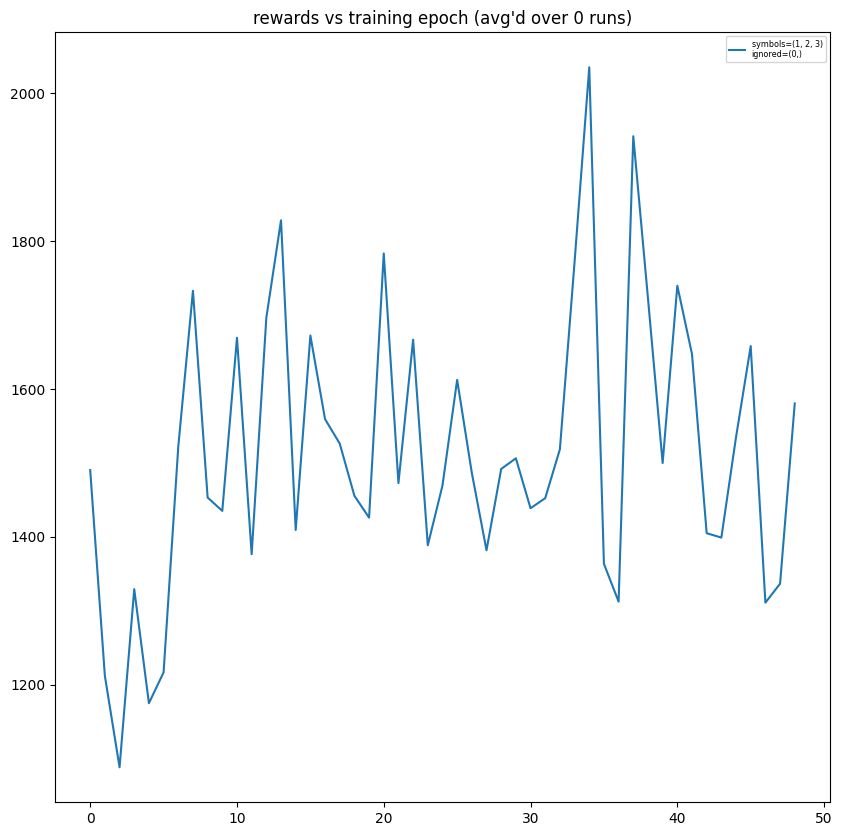

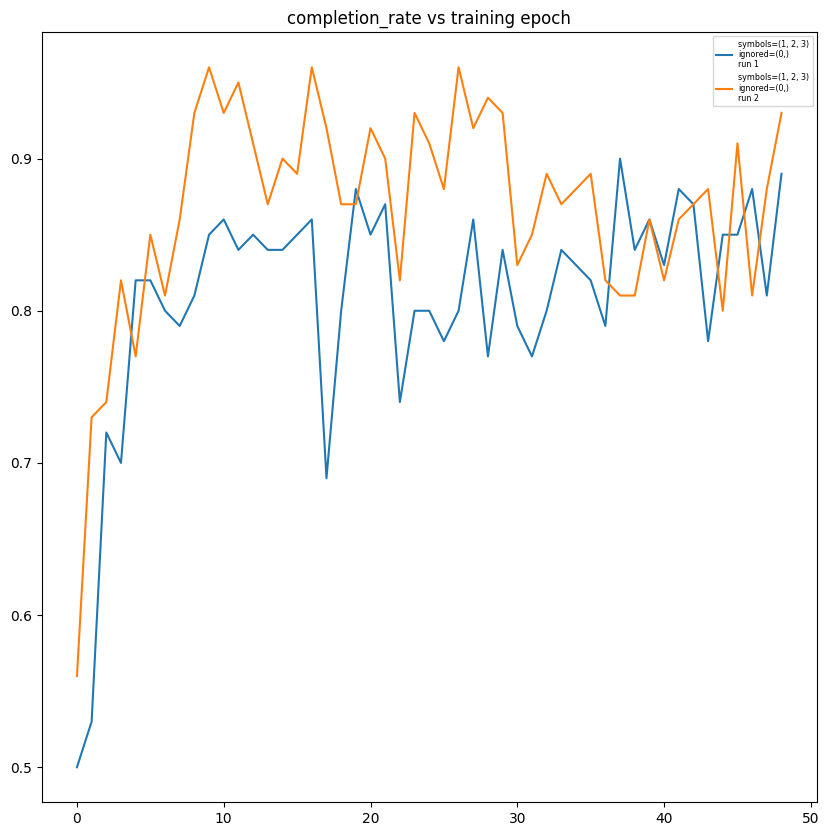

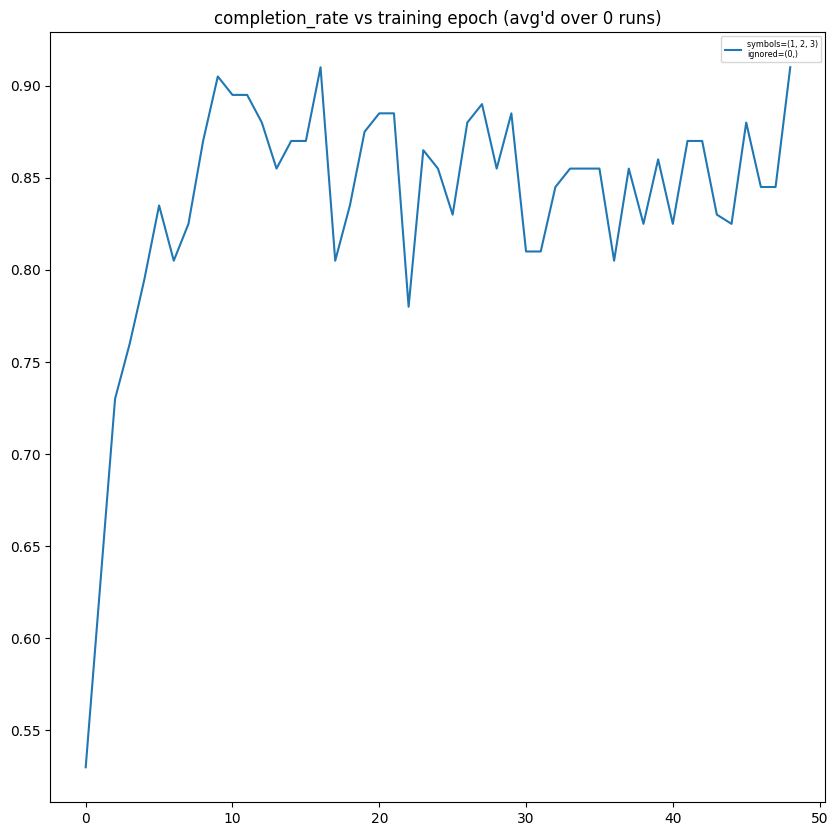

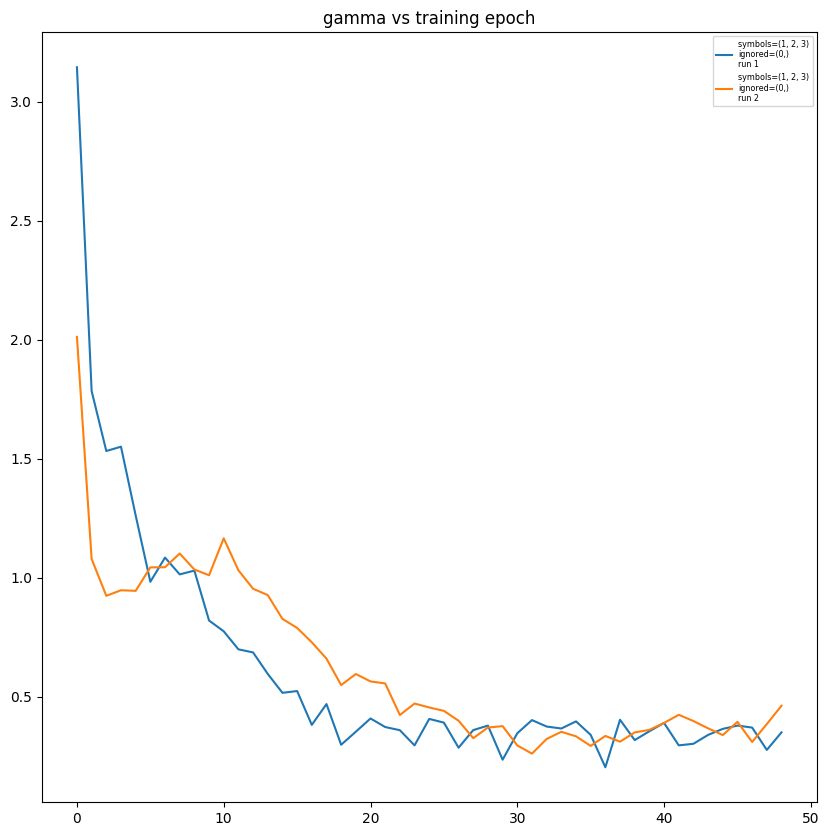

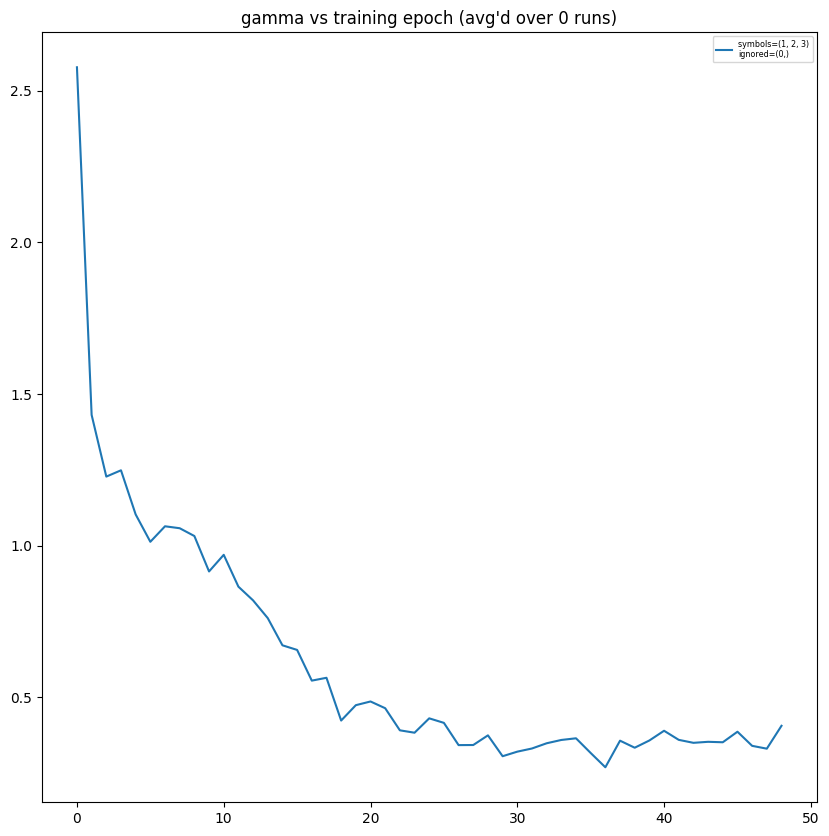

In [3]:
#######################
### Load Experiment ###
#######################

#name = "test_exp"
#name = "backwards-both_runs"
#name = 'both_runs'
#name = "small_pert"
#name = "extra_small_pert"
#name = "xxs_pert_exp"
#name = 'm-ablation'
#name = 'symbol-ablation-default_dataset'
#name = 'symbol-ablation-default_dataset_2'
#name = 'nontrivial_2'
#name = 'fwd_penalty_exp'
#name = 'fwd_penalty_exp_2'
#name = 'nontrivial_3'
name = 'BASELINE'
exp = load_experiment(name)
plot_experiment_new(exp)

In [4]:
config_idx = 2#2
run_idx = 0#1
best_model_idx = np.argmax(exp['completion_rate'][config_idx][1][run_idx])
#best_model_idx = np.argmin(exp['gamma'][config_idx][1][run_idx])
#best_model_idx = 79 #-2
#best_model_idx = -1
print(best_model_idx)
ae = exp['ae_list'][config_idx][1][run_idx][best_model_idx]
fdyn = exp['fdyn_list'][config_idx][1][run_idx][best_model_idx]
ae.encode(torch.tensor([0.,0.,0.,0.]))

37


tensor([-6.7928e-04, -9.4622e-05], device='cuda:0', grad_fn=<ViewBackward0>)

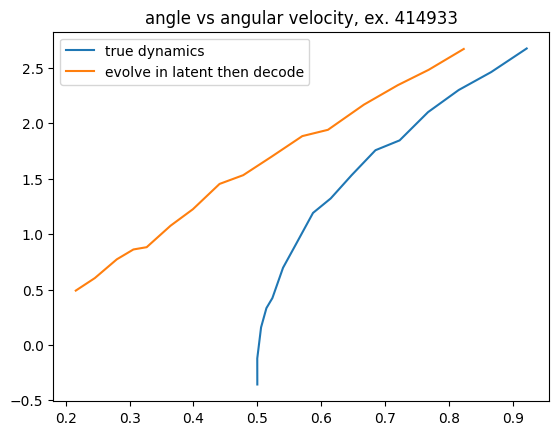

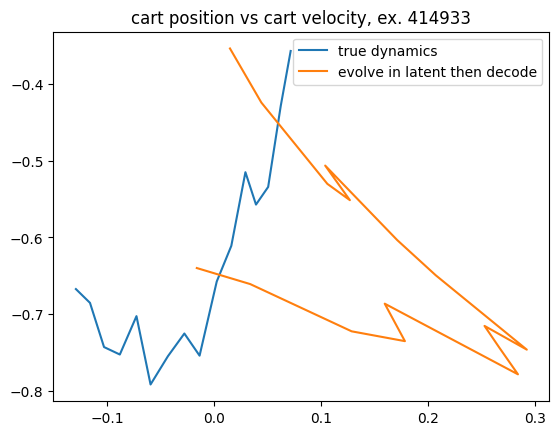

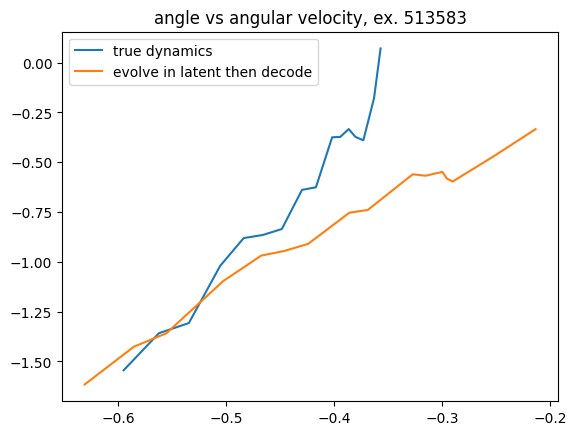

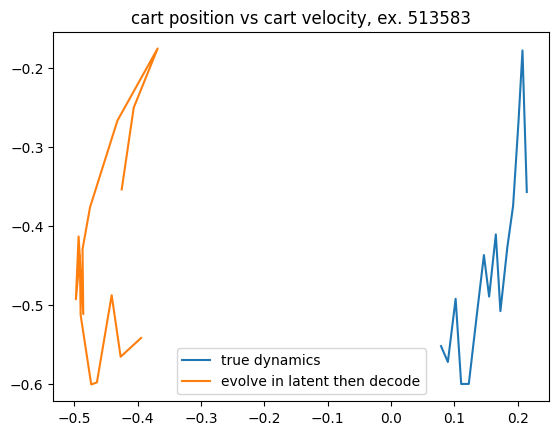

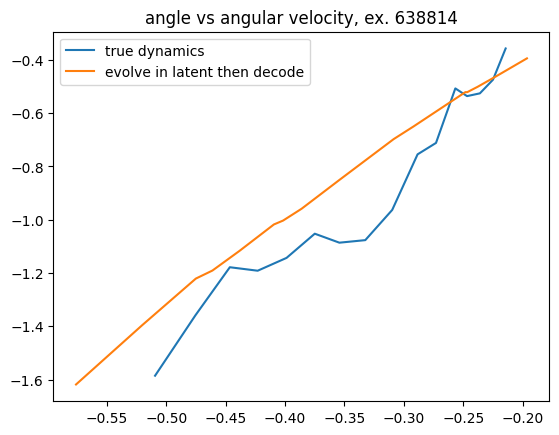

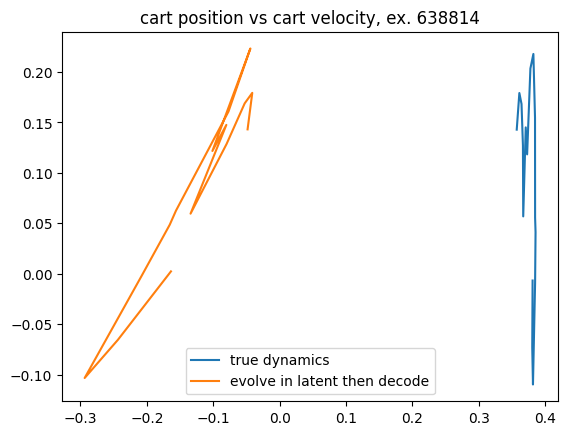

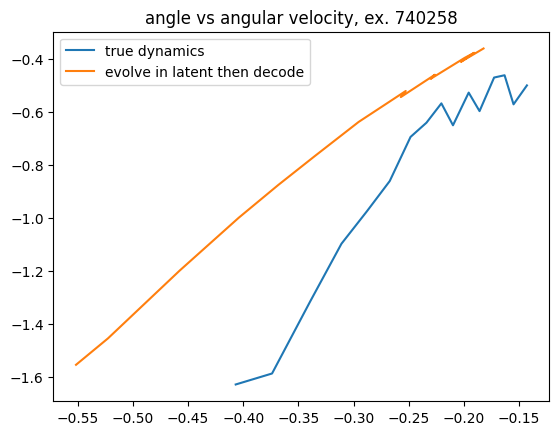

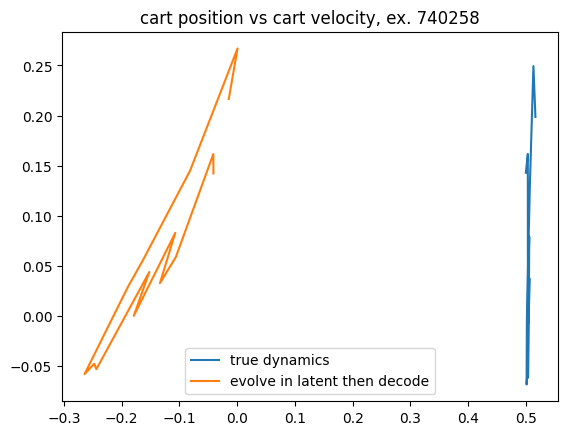

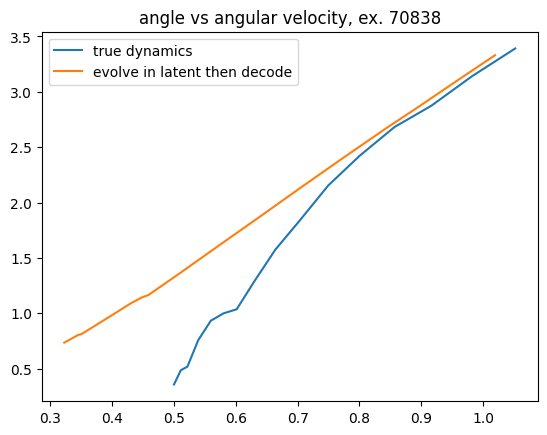

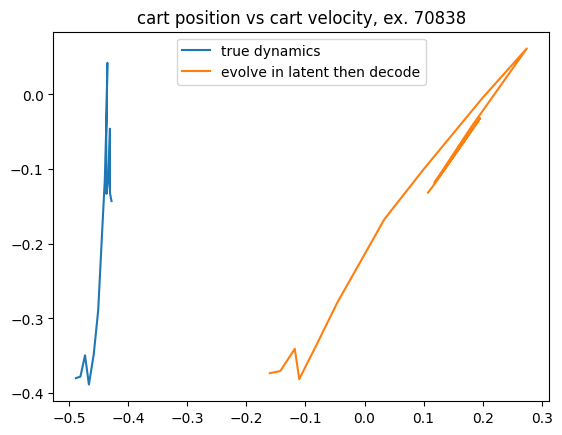

In [5]:
#########################
### Plot Trajectories ###
#########################

plot_trajectories(ae, fdyn, Xtest[0], Utest[0], 5, steps=params.traj_len)#params.m+1)

In [ ]:
######################
### Plot Stability ###
######################

from plotting import plot_stability
n_pts = 5000
eps = np.pi/6 #np.pi/3 
T = 500
tol = np.pi/2
low = [0+-eps, -eps, -eps, -eps]
high = [0+eps, eps, eps, eps]
plot_stability(ae, fdyn, n_pts, low, high, tol, T, visualize=False, latent_traj=True)

In [ ]:
##############################################
### Plot Inverse Image of Latent Norm Ball ###
##############################################

from plotting import plot_preimage_norm_ball

n = 10000
i = 1
j = 2
ivals = [0.]
jvals = [0.]
for ival in ivals:
    for jval in jvals:
        plot_preimage_norm_ball(ae, 0.25, i=i, ival=ival, j=j, jval=jval, n=n) #0.25

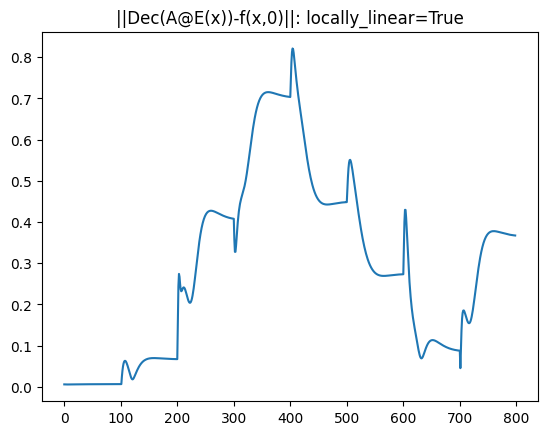

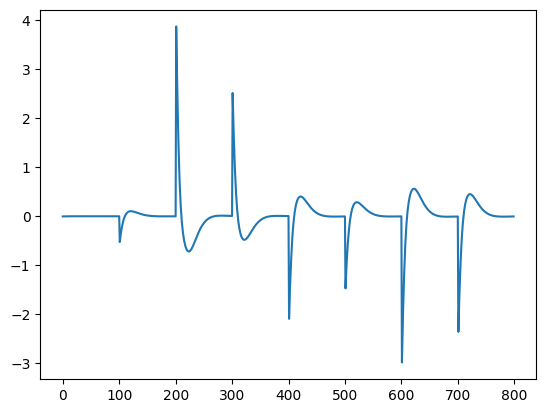

In [6]:
########################
### Stabilize System ###
########################

from controls import LQR

lqr = LQR(ae, fdyn)
stabilize_cartpole(lqr, ae, T=1, tmax=800, stabilize=True)

z_eq tensor([[-6.7928e-04, -9.4622e-05]], device='cuda:0', grad_fn=<AddmmBackward0>)


100%|██████████| 500/500 [01:20<00:00,  6.21it/s]


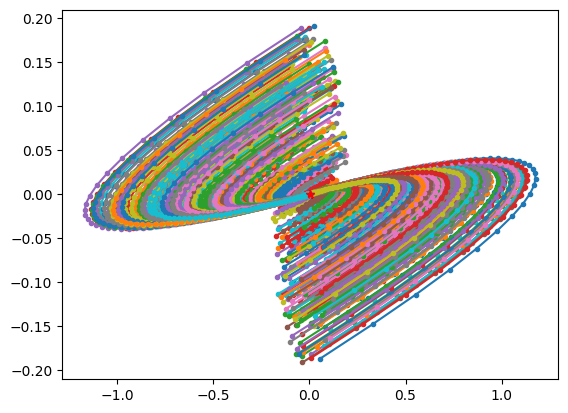

100%|██████████| 500/500 [01:07<00:00,  7.36it/s]


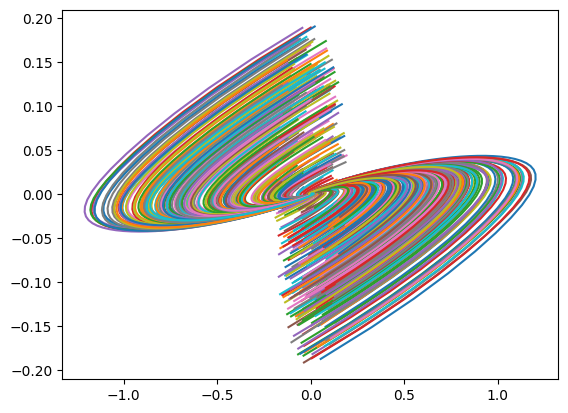

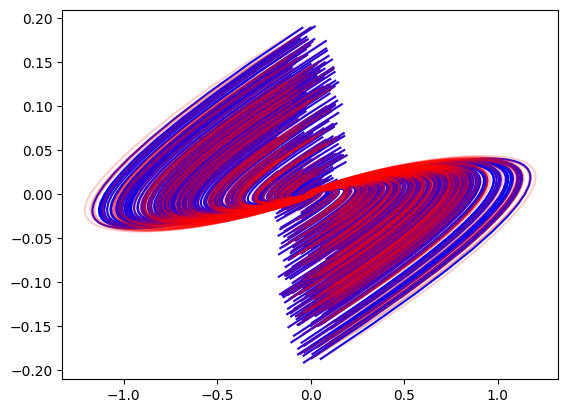

x data (500, 301, 4)
z data (500, 301, 2)
z proj data (500, 301, 2)
u data (500, 300, 1)
gamma forward 0.005863368
gamma backward 0.5516916


In [15]:
####################################
### Initialize Data for Lyapunov ###
####################################

from plotting import plot_latent_trajectories
from utils import rollout_trajectories

r = 1.2e-1#2e-3 #1e-3
r_test = r #1e-3 #5e-3
rz_init = 0.2 #0.1 #0.02 #0.080 #0.005
#rx_init = rz_init
#rz_proj_init = 0.06
n_traj = 500 #3000 #250 350 1000
T = 300
b = ae.encode(torch.tensor(4*[0.,])).cpu().detach().numpy()


for u_cost in [1]:
    lqr = LQR(ae, fdyn, u_cost=u_cost)
    pts, z_data, x_init_cond = plot_latent_trajectories(ae, fdyn, rz_init, n_traj, T=T, plot_quadratic=False, origin_spec=(b, r), lqr=lqr) #r=0.05
    x_data, z_proj_data, u_data, gammas = rollout_trajectories (ae, fdyn, lqr, x_init_cond, plot=True, n_traj=n_traj, T=T)
    gamma_fwd, gamma_bwd = gammas
    
    for zi in z_data:
        plt.plot(zi[:,0], zi[:,1], 'b-')
    for zi in z_proj_data:
        plt.plot(zi[:,0], zi[:,1], 'r-', alpha=0.2)
    plt.show()
    
    u_data = u_data[...,np.newaxis]
    
    #print(pts.shape)
    print("x data", x_data.shape)
    print("z data", z_data.shape)
    print("z proj data", z_proj_data.shape)
    print("u data", u_data.shape)
    print("gamma forward", gamma_fwd)
    print("gamma backward", gamma_bwd)

z_eq: tensor([-6.7928e-04, -9.4622e-05], device='cuda:0', grad_fn=<ViewBackward0>)
pd loss: False
dyn loss: True
lb loss False
grad loss False
rho: 0.85
c lb 0.1
l_dyn 1
l_pd 1
l_lb 1
l_grad 1e-06
using grid data, grid_density: 100
features: 128
coeff: 0.1
LyapunovGeneral(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=128, bias=False)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=1, bias=False)
  )
)
it 0: tensor([1.2979], device='cuda:0', grad_fn=<AddBackward0>)
it 1000: tensor([0.0008], device='cuda:0', grad_fn=<AddBackward0>)
it 2000: tensor([8.0906e-05], device='cuda:0', grad_fn=<AddBackward0>)
it 3000: tensor([3.6731e-05], device='cuda:0', grad_fn=<AddBackward0>)
it 4000: tensor([1.8678e-05], device='cuda:0', grad_fn=<AddBackward0>)
alpha 8.771422386169434
torch.Size([150500, 2])
Lipschitz constant tensor(79.4036, device='cuda:0', grad_fn=<MaxBackward1>)


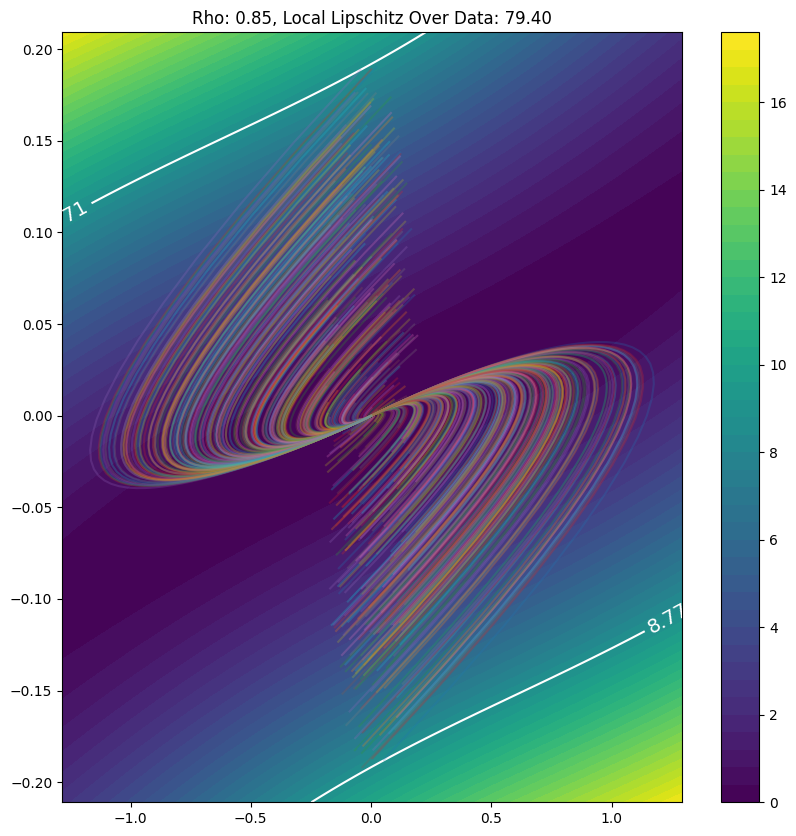

In [21]:
###############################
### Learn Lyapunov Function ###
###############################

from controls import mlp_lyapunov, mlp_lyapunov_reparam
from experiments import load_experiment

z_eq = ae.encode(torch.tensor([0.,0.,0.,0]).float())
#z_eq = torch.tensor([0.,0.]).float()
print("z_eq:", z_eq)
rho = 0.85 #0.80 #0.75
V, rho, alpha, lip = mlp_lyapunov_reparam(z_data, epochs=int(0.5e4), lr=2e-4, grid_dens=100, rho=rho, z_eq=z_eq) #ep 3e4

(852, 4)
8.6842622756958


100%|██████████| 398/398 [03:34<00:00,  1.85it/s]


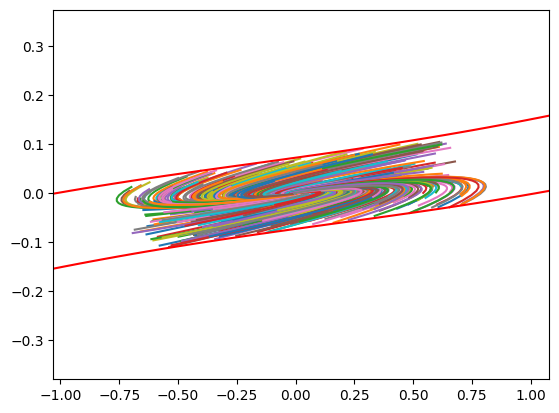

gamma fwd: 0.004822233
L: 35.22747039794922
a0: 1.4473770459493
rho: 0.85
Ly/p: 1.1325005
R: 0.09723508358001709


100%|██████████| 852/852 [07:39<00:00,  1.85it/s]


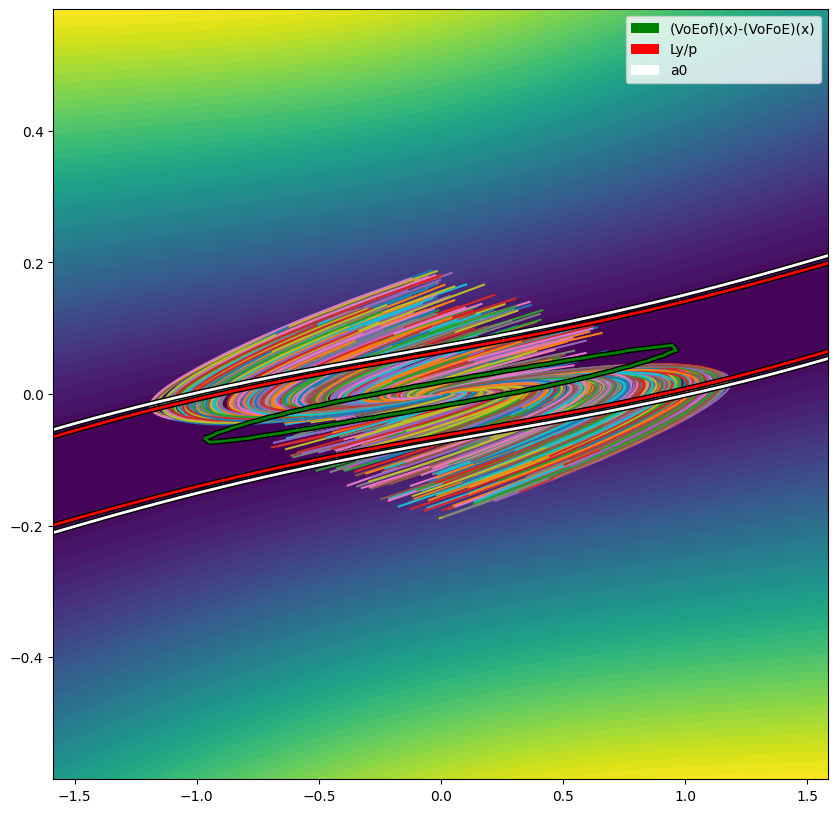

In [23]:
from theorem_tools import compute_preimage, plot_lyapunov_lvlsets

#Dx = compute_preimage(ae, z_data, 0.05, 10, uniform_sampling=True)
#Dx = compute_preimage(ae, z_data, 0.05, 7, uniform_sampling=True) #7
Dx = compute_preimage(ae, z_data, 0.25, 7, uniform_sampling=True) #0.1, 10
print(Dx.shape)
a0 = torch.max(V(ae.encode(torch.tensor(Dx)))).cpu().item()
print(a0)
Dz = z_data
plot_lyapunov_lvlsets(V, ae, fdyn, Dx, Dz, a0/6, rho, only_rollout=False, n_per_axis=150)
#plot_lyapunov_lvlsets(V, ae, fdyn, Dx, Dz, a0)

/home1/lutkus/latent_space/cartpole_lyapunov/plotting.py:116: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title("$(V \circ E)(x)$ and $f(x, (\pi\circ E)(x))$, $\dot{x}_1=x_1=0$", fontsize=16)
/home1/lutkus/latent_space/cartpole_lyapunov/plotting.py:117: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel("$\dot{x}_2$", fontsize=16, labelpad=-8)
/home1/lutkus/latent_space/cartpole_lyapunov/plotting.py:123: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title("$(V \circ E)(x)$ and $f(x, (\pi\circ E)(x))$, $\dot{x}_1=\dot{x}_2=0$", fontsize=16)
/home1/lutkus/latent_space/cartpole_lyapunov/plotting.py:126: SyntaxWarning: invalid escape sequence '\p'
  ax.quiver(XXb.cpu().detach().numpy(), YYb.cpu().detach().numpy(), fxu[:,0].cpu().detach().numpy(), fxu[:,1].cpu().detach().numpy(), label='$f(x,(\pi\circ E)(x))$',
/home1/lutkus/latent_space/cartpole_lyapunov/plotting.py:157: SyntaxWarning: invalid escape sequence '\p'
  ax.plot(Zi[:,0].cpu().detach().numpy(), Zi[:,1].c

ValueError: Contour levels must be increasing

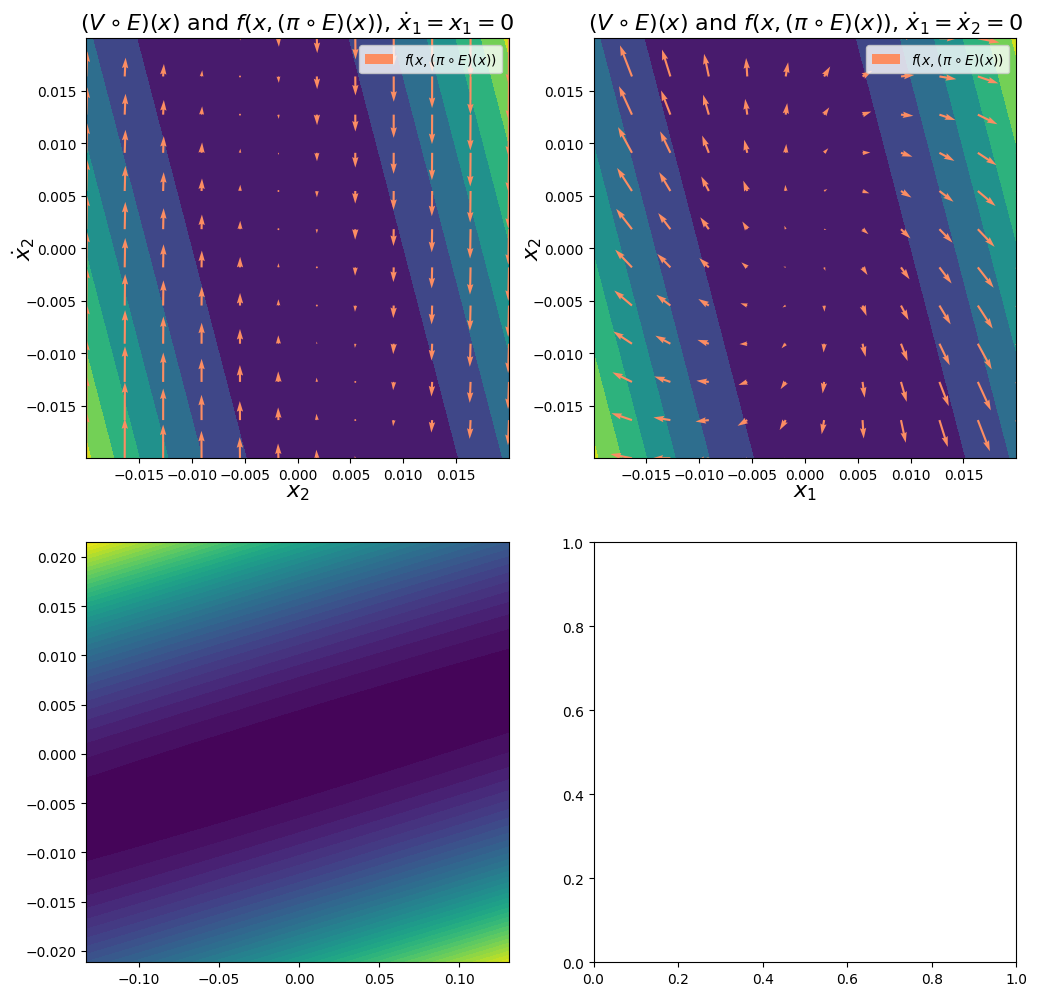

In [18]:
###################
### Make Figure ###
###################


from plotting import plot_lyapunov_slice

lqr = LQR(ae, fdyn)
#plot_lyapunov_slice(V, lqr, ae, (0.5, 0.05), (0.5, 0.05), z_data, z_proj_data)
plot_lyapunov_slice(V, lqr, ae, (rz_init, rz_init), (rz_init, rz_init), z_data, z_proj_data, 7.731, alpha)
#0.001974


In [ ]:
###############################################
### Video: Evolution of Latent Trajectories ###
###############################################


from videos import latent_projections_video
from controls import LQR
lqr = LQR(ae, fdyn)
latent_projections_video(lqr, ae, fdyn, 0.2, T=500, N=9)